<a href="https://colab.research.google.com/github/iamdung/HousePricePrediction/blob/main/intro_to_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing data

Please upload the train.csv file:


Saving train.csv to train (8).csv
🔍 Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object

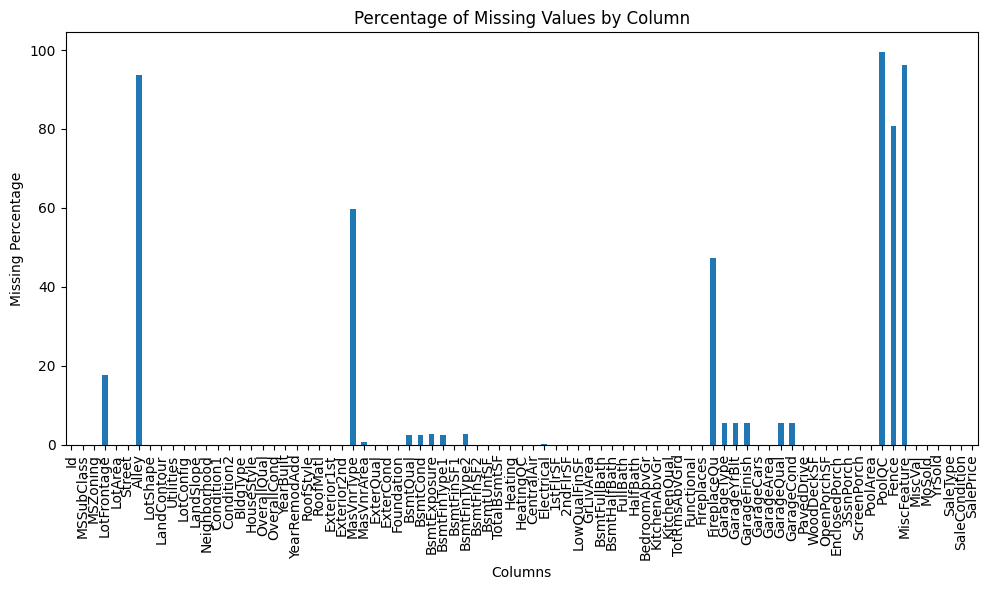


🗑️ Removing High-Missing Columns:
Dropped columns with >80.0% missing values: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']

📋 Filling Missing Values:
  Filled 259 missing values in LotFrontage with median (69.00)
  Filled 8 missing values in MasVnrArea with median (0.00)
  Filled 81 missing values in GarageYrBlt with median (1980.00)
  Filled 872 missing values in MasVnrType with mode (BrkFace)
  Filled 37 missing values in BsmtQual with mode (TA)
  Filled 37 missing values in BsmtCond with mode (TA)
  Filled 38 missing values in BsmtExposure with mode (No)
  Filled 37 missing values in BsmtFinType1 with mode (Unf)
  Filled 38 missing values in BsmtFinType2 with mode (Unf)
  Filled 1 missing values in Electrical with mode (SBrkr)
  Filled 690 missing values in FireplaceQu with mode (Gd)
  Filled 81 missing values in GarageType with mode (Attchd)
  Filled 81 missing values in GarageFinish with mode (Unf)
  Filled 81 missing values in GarageQual with mode (TA)
  Filled 81 missing values 

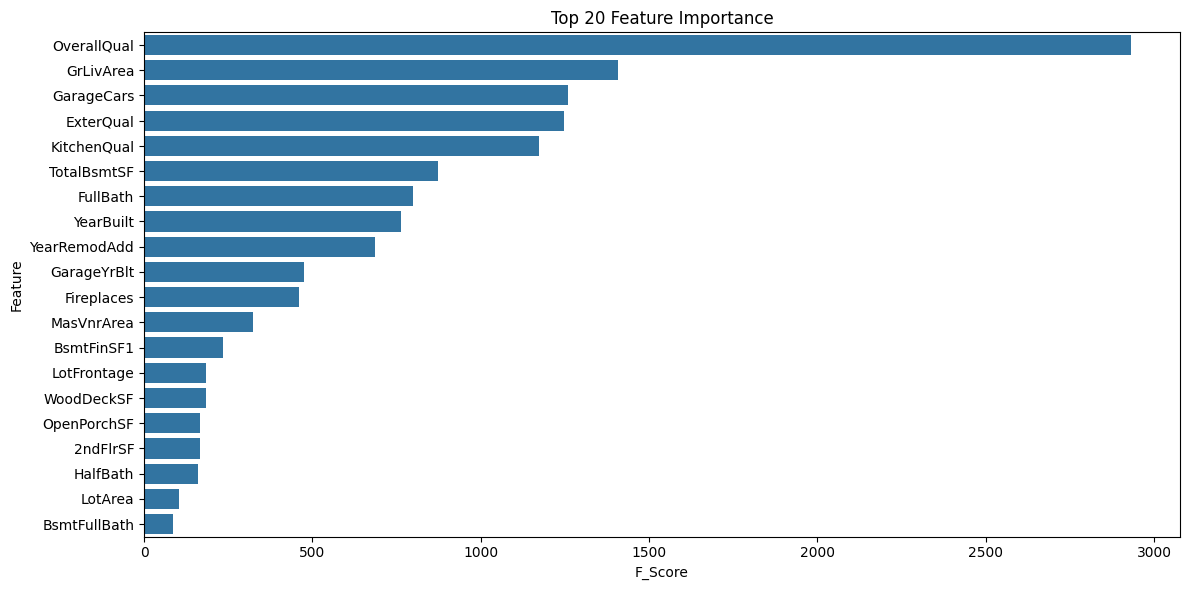

In [ ]:
from IPython import get_ipython
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class HousePricePreprocessor:
    def __init__(self, file_path, target_column='SalePrice', k_best_features=20):
        self.file_path = file_path
        self.target_column = target_column
        self.k_best_features = k_best_features


        self.df = None      # Full dataframe
        self.X = None       # Features
        self.y = None       # Target variable
        self.preprocessor = None  # Preprocessing pipeline

    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        self.X = self.df.drop(columns=[self.target_column])
        self.y = self.df[self.target_column]

        print("🔍 Initial Data Overview:")
        print(self.df.info())

        return self

    def check_invalid_values(self):
        print("\n⚠️ Invalid Values Check:")
        for col in self.df.select_dtypes(include=['int64', 'float64']).columns:
            if (self.df[col] < 0).any():
                print(f"Warning: Negative values found in {col}")
        return self

    def check_missing_data(self):
      print("\n🕳️ Missing Data Analysis:")
      missing_percentages = self.df.isnull().mean() * 100
      missing_columns = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

      if len(missing_columns) > 0:
          print("Columns with Missing Data:")
          for col, percent in missing_columns.items():
              print(f"{col}: {percent:.2f}%")

          # Visualization of missing data
          plt.figure(figsize=(10, 6))
          missing_percentages.plot(kind='bar')
          plt.title('Percentage of Missing Values by Column')
          plt.xlabel('Columns')
          plt.ylabel('Missing Percentage')
          plt.xticks(rotation=90)
          plt.tight_layout()
          plt.show()
      else:
          print("No missing data found in the dataset.")

      return self

    def remove_high_missing_columns(self, threshold=0.8):
      print("\n🗑️ Removing High-Missing Columns:")
      missing_percentages = self.df.isnull().mean()
      cols_to_drop = missing_percentages[missing_percentages > threshold].index
      self.df = self.df.drop(columns=cols_to_drop)
      self.X = self.X.drop(columns=cols_to_drop, errors='ignore')
      print(f"Dropped columns with >{threshold*100}% missing values: {cols_to_drop.tolist()}")
      return self



    def analyze_skewness(self):
        print("\n📈 Skewness Analysis:")
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        skewness = self.df[num_cols].skew()
        print("Skewness of numerical features:")
        print(skewness)

        # Apply log transformation to highly skewed features (absolute skewness > 1)
        for col in num_cols:
            if abs(skewness[col]) > 1 and col != self.target_column:
                # Check for zero or negative values before applying log transformation
                if (self.df[col] <= 0).any():
                    print(f"Skipping log transformation for {col} due to zero/negative values")
                    continue


                self.df[col] = np.log1p(self.df[col])
                self.X[col] = np.log1p(self.X[col])
                print(f"Applied log transformation to {col}")
        return self

    def transform_target(self):
        print("\n📉 Transforming Target Variable:")
        # Check skewness of target variable
        skewness = stats.skew(self.y)
        print(f"  Target variable skewness: {skewness:.4f}")

        if abs(skewness) > 0.5:  # Apply transformation only if meaningfully skewed
            self.y = np.log1p(self.y)
            print("  Applied log transformation to SalePrice")
            new_skewness = stats.skew(self.y)
            print(f"  New target variable skewness: {new_skewness:.4f}")
        else:
            print("  Target variable distribution is already approximately normal, no transformation applied")

        return self



    def detect_outliers(self):
        print("\n🔬 Outlier Detection (Z-score):")
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns

        # Fix the z-score issue by handling constant columns
        outlier_counts = 0
        for col in num_cols:
            # Check if column has some variance (not constant)
            if self.df[col].std() > 0:
                z_scores = np.abs((self.df[col] - self.df[col].mean()) / self.df[col].std())
                col_outliers = (z_scores > 3).sum()
                if col_outliers > 0:
                    print(f"{col}: {col_outliers} outliers detected (Z-score > 3)")
                outlier_counts += col_outliers
            else:
                print(f"{col}: Skipping Z-score calculation (constant column)")

        print(f"Total number of outliers (Z-score > 3): {outlier_counts}")

        # Boxplot for numerical features
        plt.figure(figsize=(15, 6))
        self.df[num_cols].boxplot()
        plt.title('Boxplot of Numerical Features')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return self


    def handle_saleprice_outliers(self):
        print("\n🚨 SalePrice Outlier Handling:")
        Q1 = self.df[self.target_column].quantile(0.25)
        Q3 = self.df[self.target_column].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        outliers = self.df[self.target_column] > upper_bound
        print(f"SalePrice: {outliers.sum()} outliers detected")
        self.df = self.df[~outliers]
        self.X = self.df.drop(columns=[self.target_column])
        self.y = self.df[self.target_column]
        return self


    def handle_outliers_iqr(self):
        print("\n🔧 Numerical Features Outlier Handling (IQR):")
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns

        for col in num_cols:
            if col != self.target_column:
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = ((self.df[col] < lower_bound) | (self.df[col] > upper_bound))
                print(f"{col}: {outliers.sum()} outliers detected (IQR)")
                self.df[col] = self.df[col].clip(lower=lower_bound, upper=upper_bound)
                self.X[col] = self.X[col].clip(lower=lower_bound, upper=upper_bound)
        return self


    def plot_target_distribution(self):
        print("\n🎯 Target Variable Distribution:")
        plt.figure(figsize=(10, 6))
        sns.histplot(self.df[self.target_column], kde=True)
        plt.title('Distribution of SalePrice')
        plt.xlabel('SalePrice')
        plt.ylabel('Count')
        plt.show()
        return self

    def explore_numerical_features(self, n=10):
        print("\n📊 Top Numerical Features Distribution:")
        # Select only numerical columns for correlation analysis
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        if self.target_column in num_cols:
            corr_with_target = self.df[num_cols].corr()[self.target_column].abs().sort_values(ascending=False)
            top_features = corr_with_target[1:n+1].index.tolist()  # Exclude SalePrice
        else:
            print("Target column is not numerical or not found in numerical columns.")
            return self

        # Ensure only numerical features are plotted
        top_features = [col for col in top_features if col in num_cols]
        if not top_features:
            print("No numerical features available for plotting.")
            return self

        fig, axes = plt.subplots(len(top_features), 3, figsize=(20, 4*len(top_features)))
        if len(top_features) == 1:
            axes = np.array([axes]).reshape(1, -1)

        for i, col in enumerate(top_features):
            # Histogram
            sns.histplot(self.df[col], kde=False, ax=axes[i, 0])
            axes[i, 0].set_title(f'Histogram of {col}')
            # Boxplot
            sns.boxplot(x=self.df[col], ax=axes[i, 1])
            axes[i, 1].set_title(f'Boxplot of {col}')
            # KDE Plot
            sns.kdeplot(self.df[col], ax=axes[i, 2])
            axes[i, 2].set_title(f'KDE Plot of {col}')
        plt.tight_layout()
        plt.show()

        return self

    def plot_feature_target_relationship(self):
        print("\n🔗 Feature-Target Relationship:")
        top_features = ['GrLivArea', 'OverallQual', 'TotalBsmtSF']


        available_features = [f for f in top_features if f in self.df.columns]
        if not available_features:
            print("None of the specified features are available in the dataset.")
            return self

        plt.figure(figsize=(15, 5))
        for i, feature in enumerate(available_features, 1):
            plt.subplot(1, len(available_features), i)
            plt.scatter(self.df[feature], self.df[self.target_column], alpha=0.5)
            plt.title(f'{feature} vs SalePrice')
            plt.xlabel(feature)
            plt.ylabel('SalePrice')
        plt.tight_layout()
        plt.show()
        return self

    def top_correlated_features(self, n=10):
        print(f"\n🏅 Top {n} Features Correlated with {self.target_column}:")
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        if self.target_column in num_cols:
            corr_with_target = self.df[num_cols].corr()[self.target_column].sort_values(ascending=False)
            print(corr_with_target[1:n+1])
        else:
            print("Target column is not numerical or not found in numerical columns.")
        return self

    def plot_feature_importance(self):
        print("\n🏆 Feature Importance Analysis:")
        # Get numerical columns excluding the target
        num_cols = self.X.select_dtypes(include=['int64', 'float64']).columns

        if len(num_cols) == 0:
            print("No numerical features available for feature importance analysis.")
            return self

        # Prepare data: impute missing values first
        imputer = SimpleImputer(strategy='median')
        X_num_imputed = imputer.fit_transform(self.X[num_cols])

        # Handle constant columns and low variance
        variances = np.var(X_num_imputed, axis=0)
        valid_cols = [i for i, v in enumerate(variances) if v > 1e-10]

        if not valid_cols:
            print("No features with sufficient variance found for feature importance analysis.")
            return self


        X_filtered = X_num_imputed[:, valid_cols]
        filtered_names = num_cols[valid_cols].tolist()


        selector = SelectKBest(score_func=f_regression, k=min(self.k_best_features, len(filtered_names)))
        _ = selector.fit_transform(X_filtered, self.y)


        feature_scores = selector.scores_

        # Create a DataFrame for better visualization
        importance_df = pd.DataFrame({
            'Feature': filtered_names,
            'F_Score': feature_scores
        }).sort_values('F_Score', ascending=False)

        # Plot top k features
        plt.figure(figsize=(12, 6))
        top_k = min(self.k_best_features, len(importance_df))
        sns.barplot(x='F_Score', y='Feature', data=importance_df.head(top_k))
        plt.title(f'Top {top_k} Feature Importance')
        plt.tight_layout()
        plt.show()

        return self

    def analyze_correlation(self):
        print("\n🔗 Correlation Analysis:")
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        # Check for low-variance columns
        low_variance_cols = [col for col in num_cols if self.df[col].std() < 1e-4]
        if low_variance_cols:
            print(f"Warning: Low variance in columns {low_variance_cols}. Excluding from correlation analysis.")
            num_cols = [col for col in num_cols if col not in low_variance_cols]

        if len(num_cols) == 0:
            print("No numerical columns available for correlation analysis.")
            return self

        corr_matrix = self.df[num_cols].corr()

        # Correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", square=True)
        plt.title('Correlation Heatmap of Numerical Features')
        plt.tight_layout()
        plt.show()

        # Identify highly correlated features
        high_corr = np.where(np.abs(corr_matrix) > 0.8)
        high_corr_list = [(corr_matrix.columns[x], corr_matrix.columns[y])
                          for x, y in zip(*high_corr) if x != y and x < y]

        if high_corr_list:
            print("\nHighly Correlated Features:")
            for feat1, feat2 in high_corr_list:
                print(f"{feat1} - {feat2}: {corr_matrix.loc[feat1, feat2]:.2f}")

        return self

    def handle_collinearity(self, threshold=0.8):
        print("\n🛠️ Handling Collinearity:")
        num_cols = self.df.select_dtypes(include=['int64', 'float64']).columns

        # Skip if only one numerical column or target only
        if len(num_cols) <= 1:
            print("Not enough numerical features for collinearity analysis.")
            return self

        corr_matrix = self.df[num_cols].corr().abs()

        # Create a mask for the upper triangle
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Find features with correlation greater than threshold
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

        if self.target_column in to_drop:
            to_drop.remove(self.target_column)

        if to_drop:
            self.df = self.df.drop(columns=to_drop)
            self.X = self.X.drop(columns=to_drop, errors='ignore')
            print(f"Dropped columns due to high collinearity: {to_drop}")
        else:
            print("No features found with collinearity above the threshold.")

        return self

    def check_categorical_cardinality(self):
        print("\n🔢 Categorical Cardinality Check:")
        cat_cols = self.X.select_dtypes(include=['object']).columns
        for col in cat_cols:
            unique_values = self.X[col].nunique()
            value_counts = self.X[col].value_counts()
            top_values = value_counts.head(5).index.tolist()

            print(f"{col}: {unique_values} unique values")
            print(f"  Top values: {', '.join(map(str, top_values))}")

            if unique_values > 50:
                print(f"  Warning: High cardinality in {col}")

            # Check for imbalanced categories
            if unique_values > 1:
                imbalance_ratio = value_counts.iloc[0] / value_counts.iloc[-1]
                if imbalance_ratio > 20:
                    print(f"  Warning: Highly imbalanced categories in {col} (ratio: {imbalance_ratio:.1f})")

        return self

    def encode_ordinal_features(self):
        print("\n🔠 Encoding Ordinal Features:")
        ordinal_cols = ['OverallQual', 'ExterQual', 'KitchenQual']
        ordinal_mapping = {
            'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
            'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        }

        for col in ordinal_cols:
            if col in self.X.columns:
                if col in ordinal_mapping:
                    # Handle missing values for categorical columns before mapping
                    missing = self.X[col].isna()
                    if missing.any():
                        print(f"  Warning: Found {missing.sum()} missing values in {col}, filling with most frequent value")
                        mode_value = self.X[col].mode()[0]

                        self.X[col] = self.X[col].fillna(mode_value)
                        self.df[col] = self.df[col].fillna(mode_value)

                    self.X[col] = self.X[col].map(ordinal_mapping[col])
                    self.df[col] = self.df[col].map(ordinal_mapping[col])
                    print(f"  Encoded {col} using ordinal mapping")
                else:
                    self.X[col] = self.X[col].astype(int)
                    self.df[col] = self.df[col].astype(int)
                    print(f"  Converted {col} to integer type")
        return self


    def create_preprocessing_pipeline(self):
        num_cols = self.X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        cat_cols = self.X.select_dtypes(include=['object']).columns.tolist()

        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        self.preprocessor = ColumnTransformer([
            ('num', num_pipeline, num_cols),
            ('cat', cat_pipeline, cat_cols)
        ])

        return self

    def fill_missing_values(self):
        print("\n📋 Filling Missing Values:")

        # Handle numerical columns
        num_cols = self.X.select_dtypes(include=['int64', 'float64']).columns
        for col in num_cols:
            missing = self.X[col].isnull().sum()
            if missing > 0:
                median_val = self.X[col].median()

                self.X = self.X.copy()
                self.df = self.df.copy()
                self.X[col] = self.X[col].fillna(median_val)
                self.df[col] = self.df[col].fillna(median_val)
                print(f"  Filled {missing} missing values in {col} with median ({median_val:.2f})")

        # Handle categorical columns
        cat_cols = self.X.select_dtypes(include=['object']).columns
        for col in cat_cols:
            missing = self.X[col].isnull().sum()
            if missing > 0:
                mode_val = self.X[col].mode()[0]

                self.X[col] = self.X[col].fillna(mode_val)
                self.df[col] = self.df[col].fillna(mode_val)
                print(f"  Filled {missing} missing values in {col} with mode ({mode_val})")

        return self

    def process_data(self):
        # Chain of operations for data preprocessing
        (self.load_data()
          #Processing data
            .check_invalid_values()

            .check_missing_data()
            .remove_high_missing_columns(threshold=0.8)
            .fill_missing_values()  # Fill missing values before correlation analysis
          #Log tranformation
            #.analyze_skewness()
            #.plot_target_distribution()
            #.plot_feature_target_relationship()
            #.top_correlated_features(n=10)
            #.analyze_correlation()

            #.detect_outliers()
            #.handle_saleprice_outliers()
            #.handle_outliers_iqr()

            #.explore_numerical_features(n=10)
            #collinearity
            .handle_collinearity(threshold=0.8)
            .check_categorical_cardinality()
            .encode_ordinal_features()
            .create_preprocessing_pipeline()
        )

        # Transform target variable
        self.transform_target()

        X_processed = self.preprocessor.fit_transform(self.X)

        # Get feature names after preprocessing
        num_cols = self.X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        cat_cols = self.X.select_dtypes(include=['object']).columns.tolist()

        try:
            cat_cols_encoded = self.preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)
            all_feature_names = num_cols + list(cat_cols_encoded)
        except:
            print("Warning: Could not retrieve feature names, using generic column names instead")
            all_feature_names = [f"feature_{i}" for i in range(X_processed.shape[1])]

        X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(
            X_processed_df, self.y, test_size=0.2, random_state=42
        )

        print("\n✅ Data Processing Complete:")
        print("Dataset Summary:")
        print(f"  Total Features: {X_train.shape[1]}")
        print(f"  Training Set Samples: {X_train.shape[0]} rows")
        print(f"  Validation Set Samples: {X_val.shape[0]} rows")
        print("\nData Split Breakdown:")
        print(f"  Training Data (%): {X_train.shape[0] / (X_train.shape[0] + X_val.shape[0]) * 100:.2f}%")
        print(f"  Validation Data (%): {X_val.shape[0] / (X_train.shape[0] + X_val.shape[0]) * 100:.2f}%")
        print("\nTarget Variable:")
        print(f"  Training Set Target Mean: {y_train.mean():.2f}")
        print(f"  Training Set Target Standard Deviation: {y_train.std():.2f}")

        # Plot feature importance as a final step
        self.plot_feature_importance()

        return X_train, X_val, y_train, y_val

def main():
    try:
        from google.colab import files
        is_colab = True
    except ImportError:
        is_colab = False

    if is_colab:
        print("Please upload the train.csv file:")
        uploaded = files.upload()

        file_name = list(uploaded.keys())[0]
    else:
        # For non-Colab environments
        file_name = input("Enter the path to your train.csv file: ")

    # Create preprocessor and process data
    preprocessor = HousePricePreprocessor(file_name)
    global X_train, X_val, y_train, y_val
    X_train, X_val, y_train, y_val = preprocessor.process_data()

if __name__ == "__main__":
    main()

# Linear Regression

Create selected features

In [ ]:
selected_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',  'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea']  # Removed 'GarageArea', 'TotRmsAbvGrd', 'GarageYrBilt'
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
print(f"X_train_selected shape: {X_train_selected.shape}")
print(f"X_val_selected shape: {X_val_selected.shape}")

KeyError: "['1stFlrSF'] not in index"

Reshape for standard format

In [ ]:
#Check the shape of reshape test set
y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

y_train shape: (1168, 1)
y_val shape: (292, 1)


=>y = X*W1 + w0

Using Standard Scaler and Gradient Descent to calculate the mean squared error

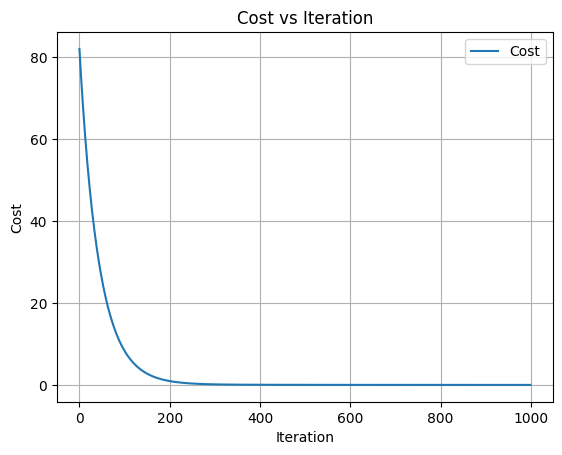

Mean Absolute Percentage Error on validation set: 0.0090
Mean Square Error on validation set: 0.0242
Root Mean Square Error on validation set: 0.1555


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val = scaler.transform(X_val_selected)

y_train_np = y_train.reshape(-1, 1)
y_val_np = y_val.reshape(-1, 1)


X_b_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_b_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]

numOfIteration = 1000
cost = np.zeros((numOfIteration, 1))
learning_rate = 0.00001
w = np.random.randn(X_b_train.shape[1], 1)

for i in range(numOfIteration):
    r = np.dot(X_b_train, w) - y_train_np
    cost[i] = 0.5 * np.mean(r ** 2)
    w -= learning_rate * np.dot(X_b_train.T, r)

plt.plot(range(numOfIteration), cost, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration')
plt.grid(True)
plt.legend()
plt.show()

y_val_pred = np.dot(X_b_val, w)
mse = mean_squared_error(y_val_np, y_val_pred)
mape = mean_absolute_percentage_error(y_val_np, y_val_pred)
rmse = np.sqrt(mse)
print(f"Mean Absolute Percentage Error on validation set: {mape:.4f}")
print(f"Mean Square Error on validation set: {mse:.4f}")
print(f"Root Mean Square Error on validation set: {rmse:.4f}")




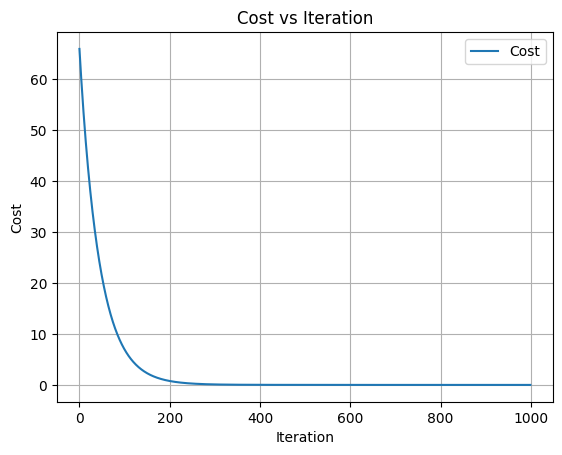

Mean Absolute Percentage Error on validation set: 0.0083
Mean Squared Error on validation set: 0.0200
Root Mean Square Error on validation set: 0.1415


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val = scaler.transform(X_val_selected)

y_train_np = y_train.reshape(-1, 1)
y_val_np = y_val.reshape(-1, 1)

X_b_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_b_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]

numOfIteration = 1000
cost = np.zeros((numOfIteration, 1))
learning_rate = 0.00001
w = np.random.randn(X_b_train.shape[1], 1)

for i in range(numOfIteration):
    r = np.dot(X_b_train, w) - y_train_np
    cost[i] = 0.5 * np.mean(r ** 2)
    w -= learning_rate * np.dot(X_b_train.T, r)

plt.plot(range(numOfIteration), cost, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration')
plt.grid(True)
plt.legend()
plt.show()

y_val_pred = np.dot(X_b_val, w)
mse = np.mean((y_val_pred - y_val_np) ** 2)
mape = mean_absolute_percentage_error(y_val_np, y_val_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Percentage Error on validation set: {mape:.4f}")
print(f"Mean Squared Error on validation set: {mse:.4f}")
print(f"Root Mean Square Error on validation set: {rmse:.4f}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from google.colab import files # Import files for Colab upload

# Đọc dữ liệu test
try:
    from google.colab import files
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    # Upload the file if in Colab
    print("Please upload the test.csv file:")
    uploaded_test = files.upload()

    # Get the first (and assumed only) uploaded file
    test_file_name = list(uploaded_test.keys())[0]
else:
    # For non-Colab environments, prompt for path
    test_file_name = input("Enter the path to your test.csv file: ")

test_data = pd.read_csv(test_file_name)


# Chọn các đặc trưng đã sử dụng trong huấn luyện
selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

# Xử lý giá trị thiếu (điền bằng 0) - Consider a more robust imputation strategy if appropriate
test_data_selected = test_data[selected_features].fillna(0)

# Chuẩn hóa dữ liệu test (sử dụng scaler đã fit trên tập huấn luyện)
# Ensure scaler object 'scaler' is available from previous cells
try:
    x_test = scaler.transform(test_data_selected)
except NameError:
    print("Error: 'scaler' object not found. Please run the previous training cells first.")
    # You might want to exit or handle this error more gracefully
    exit()


# Thêm cột bias (1)
X_b_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]

# Dự đoán SalePrice
# Ensure weight vector 'w' is available from previous training cells
try:
    y_test_pred = np.dot(X_b_test, w)
except NameError:
     print("Error: 'w' object not found. Please run the previous training cells first to get the model weights.")
     # You might want to exit or handle this error more gracefully
     exit()


# Revert log transformation if applied to training target
# Assuming the target variable 'SalePrice' in the original training data was log-transformed
# If y_train was log1p transformed, revert y_test_pred with expm1
# Check if the original target was likely transformed
# This is a heuristic; a better approach would be to store the transformation state.
if np.mean(y_test_pred) < 1000 and np.mean(test_data['SalePrice'] if 'SalePrice' in test_data.columns else [0]) > 1000:
    y_test_pred = np.expm1(y_test_pred)
    print("Applied expm1 to predictions, assuming target was log1p transformed.")
else:
     print("Did not apply expm1 to predictions.")


# Tạo DataFrame kết quả với Id và SalePrice dự đoán
results = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': y_test_pred.flatten()  # Làm phẳng mảng để chuyển thành cột
})

# Lưu kết quả ra file CSV
results.to_csv('predicted_saleprice.csv', index=False)

print("Kết quả dự đoán đã được lưu vào file 'predicted_saleprice.csv'")
try:
    from google.colab import files
    files.download('predicted_saleprice.csv')
except ImportError:
    print("Không thể tự động tải file về máy. Vui lòng tải thủ công nếu không dùng Google Colab.")

Please upload the test.csv file:


Saving test.csv to test (1).csv
Did not apply expm1 to predictions.
Kết quả dự đoán đã được lưu vào file 'predicted_saleprice.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ridge


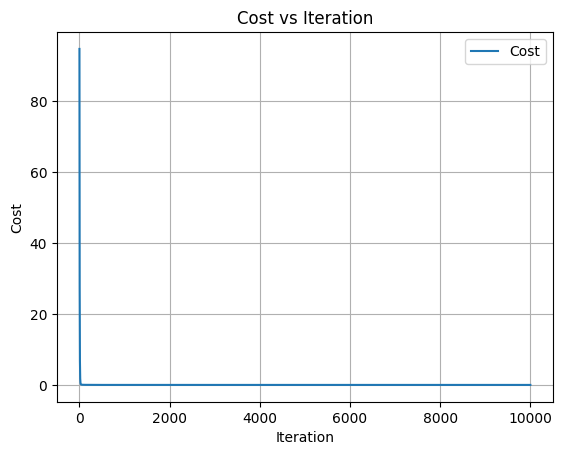

Mean Absolute Persentage Error on validation set: 0.0092


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val = scaler.transform(X_val_selected)

y_train_np = y_train.reshape(-1, 1)
y_val_np = y_val.reshape(-1, 1)


X_b_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_b_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]

numOfIteration = 10000
cost = np.zeros((numOfIteration, 1))
learning_rate = 0.0001
w = np.random.randn(X_b_train.shape[1], 1)
alpha = 0.1  # hệ số regularization

for i in range(numOfIteration):
    r = np.dot(X_b_train, w) - y_train_np
    cost[i] = 0.5 * np.mean(r ** 2) + 0.5 * alpha * np.sum(w[1:] ** 2)
    grad = np.dot(X_b_train.T, r)
    w[1:] -= learning_rate * (grad[1:] + alpha * w[1:])
    w[0] -= learning_rate * grad[0]  # bias không regularize

plt.plot(range(numOfIteration), cost, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration')
plt.grid(True)
plt.legend()
plt.show()

y_val_pred = np.dot(X_b_val, w)
mape = np.mean(np.abs(y_val_pred - y_val_np) / y_val_np)

print(f"Mean Absolute Persentage Error on validation set: {mape:.4f}")



LASSO

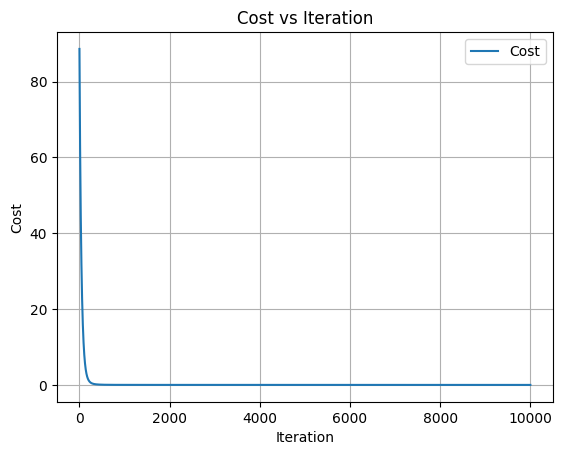

Mean Absolute Persentage Error on validation set: 0.009193228574840626


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val = scaler.transform(X_val_selected)

y_train_np = y_train.reshape(-1, 1)
y_val_np = y_val.reshape(-1, 1)


X_b_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_b_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]

numOfIteration = 10000
cost = np.zeros((numOfIteration, 1))
learning_rate = 0.00001
alpha = 0.0005  # smaller alpha recommended for LASSO

w = np.random.randn(X_b_train.shape[1], 1)
cost_lasso = np.zeros((numOfIteration, 1))

for i in range(numOfIteration):
    r = np.dot(X_b_train, w) - y_train_np
    cost_lasso[i] = 0.5 * np.mean(r ** 2) + alpha * np.sum(np.abs(w[1:]))
    grad = np.dot(X_b_train.T, r)
    w[1:] -= learning_rate * (grad[1:] + alpha * np.sign(w[1:]))  # subgradient L1
    w[0] -= learning_rate * grad[0]

plt.plot(range(numOfIteration), cost_lasso, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration')
plt.grid(True)
plt.legend()
plt.show()

y_val_pred = np.dot(X_b_val, w)
mse = np.mean(np.abs(y_val_pred - y_val_np) / y_val_np)

print(f"Mean Absolute Persentage Error on validation set: {mse:}")



Elastic Net

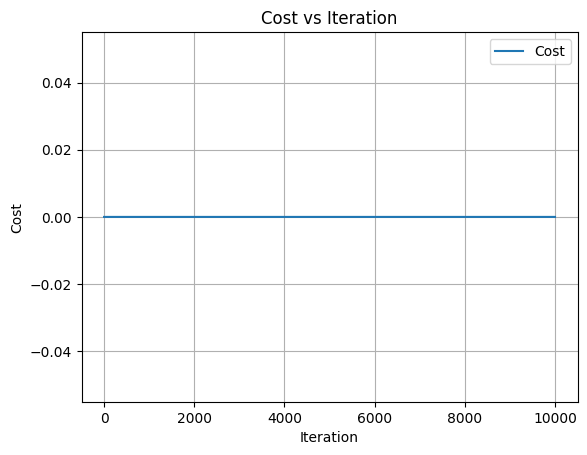

Mean Absolute Persentage Error on validation set: 0.009213400108880181


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val = scaler.transform(X_val_selected)

y_train_np = y_train.reshape(-1, 1)
y_val_np = y_val.reshape(-1, 1)


X_b_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_b_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]

numOfIteration = 10000
cost = np.zeros((numOfIteration, 1))
learning_rate = 0.0001
alpha1 = 0.0005  # L2
alpha2 = 0.0005  # L1

w = np.random.randn(X_b_train.shape[1], 1)
cost_elastic = np.zeros((numOfIteration, 1))

for i in range(numOfIteration):
    r = np.dot(X_b_train, w) - y_train_np
    cost_elastic[i] = 0.5 * np.mean(r ** 2) + alpha1 * np.sum(w[1:] ** 2) + alpha2 * np.sum(np.abs(w[1:]))
    grad = np.dot(X_b_train.T, r)
    w[1:] -= learning_rate * (grad[1:] + alpha1 * w[1:] + alpha2 * np.sign(w[1:]))
    w[0] -= learning_rate * grad[0]

plt.plot(range(numOfIteration), cost, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration')
plt.grid(True)
plt.legend()
plt.show()

y_val_pred = np.dot(X_b_val, w)
mape = np.mean(np.abs(y_val_pred - y_val_np) / y_val_np)

print(f"Mean Absolute Persentage Error on validation set: {mape}")



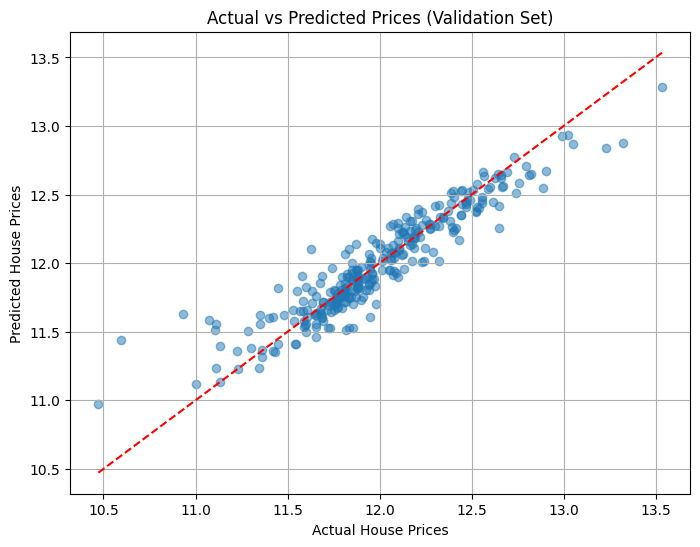

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val_np, y_val_pred, alpha=0.5)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs Predicted Prices (Validation Set)")
plt.plot([y_val_np.min(), y_val_np.max()], [y_val_np.min(), y_val_np.max()], 'r--')  # Đường y = x
plt.grid(True)
plt.show()

## Testing using sklearn model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val = scaler.transform(X_val_selected)

x_train_bias = np.c_[np.ones((x_train.shape[0], 1)), x_train]
x_val_bias = np.c_[np.ones((x_val.shape[0], 1)), x_val]

model = LinearRegression(fit_intercept=False)
model.fit(x_train_bias, y_train)

y_val_pred = model.predict(x_val_bias)

mape = np.mean(np.abs(y_val_pred.reshape(-1, 1) - y_val.reshape(-1, 1)) / y_val.reshape(-1, 1))
print(f"Mean Absolute Percentage Error on validation set using LinearRegression: {mape:}")


Mean Absolute Percentage Error on validation set using LinearRegression: 0.008009287927807354


Adam Optimizer

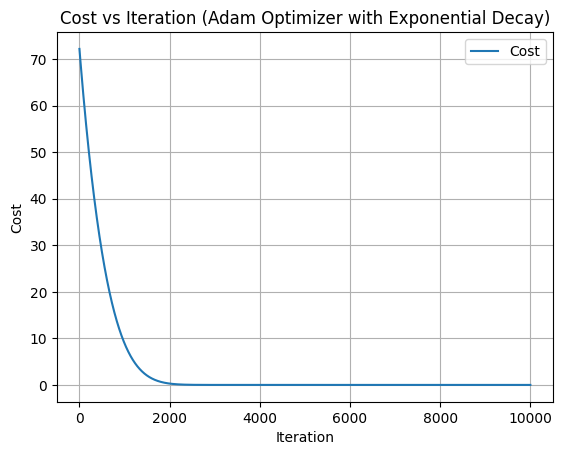

Mean Absolute Percentage Error on validation set (Adam Optimizer with Exponential Decay): 0.00800929


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Danh sách đặc trưng
selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

# Chuẩn hoá
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val = scaler.transform(X_val_selected)

# Thêm bias
X_b_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_b_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]

# Chuyển y về shape (n, 1)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

# Adam Optimizer
n_iter = 10000
initial_lr = 0.01  # Learning rate ban đầu
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Khởi tạo
m = np.zeros((X_b_train.shape[1], 1))
v = np.zeros((X_b_train.shape[1], 1))
w = np.random.randn(X_b_train.shape[1], 1) * 0.01  # scale nhỏ

cost_history = []

# Learning rate scheduler (Exponential Decay)
decay_rate = 0.96  # Hệ số giảm
decay_steps = 1000  # Sau mỗi 1000 bước giảm learning rate

for t in range(1, n_iter + 1):
    # Tính learning rate mới
    lr = initial_lr * decay_rate ** (t / decay_steps)

    # Gradient descent
    preds = np.dot(X_b_train, w)
    residuals = preds - y_train
    grad = np.dot(X_b_train.T, residuals) / len(y_train)

    # Adam
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    w -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

    # Tính cost
    cost = 0.5 * np.mean((np.dot(X_b_train, w) - y_train) ** 2)
    cost_history.append(cost)

# Vẽ biểu đồ cost
plt.plot(range(n_iter), cost_history, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost vs Iteration (Adam Optimizer with Exponential Decay)')
plt.grid(True)
plt.legend()
plt.show()

# Dự đoán validation
y_val_pred = np.dot(X_b_val, w)

# Tính MAPE - giống như cách bạn tính MSE trong code gốc
mape_val = np.mean(np.abs(y_val_pred - y_val) / y_val)
print(f"Mean Absolute Percentage Error on validation set (Adam Optimizer with Exponential Decay): {mape_val:.8f}")

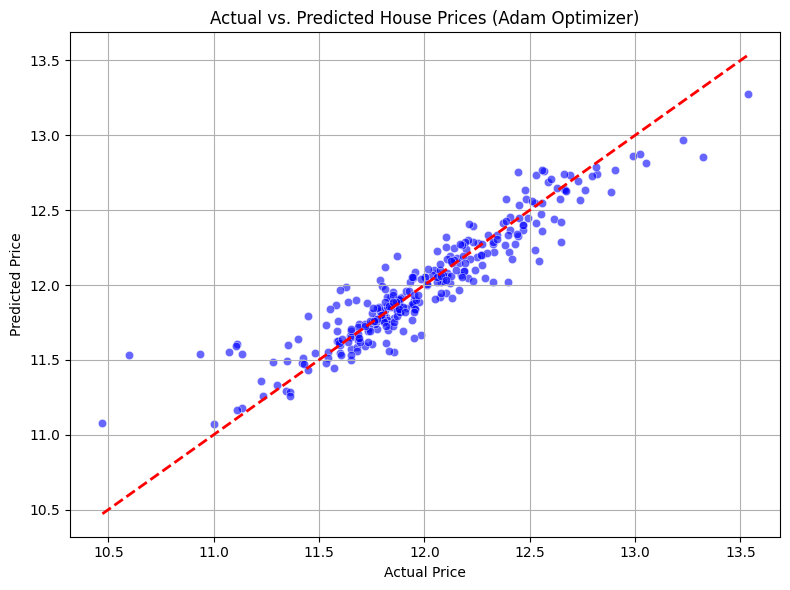

In [ ]:
import seaborn as sns

# Tạo biểu đồ scatter giữa giá thực tế và giá dự đoán
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val.flatten(), y=y_val_pred.flatten(), alpha=0.6, color='blue')

# Đường y = x để đối chiếu
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted House Prices (Adam Optimizer)')
plt.grid(True)
plt.tight_layout()
plt.show()


Best combination of features

In [ ]:
import itertools
import numpy as np

from sklearn.preprocessing import StandardScaler
top_features = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual', 'KitchenQual',
    'YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF',
    'GarageYrBlt', 'Fireplaces', 'LotArea', 'OpenPorchSF', 'MasVnrArea',
    'LotFrontage', '2ndFlrSF', 'BsmtFinSF1', 'WoodDeckSF', 'HalfBath'
]

best_mape = float('inf')
best_features = None

for k in range(1, len(top_features) + 1):
  for combination in itertools.combinations(top_features, k):
    selected_features = list(combination)
    X_train_selected = X_train[selected_features]
    X_val_selected = X_val[selected_features]

    #normalize the features
    scaler = StandardScaler()
    x_train = scaler.fit_transform(X_train_selected)
    x_val = scaler.transform(X_val_selected)
    y_train_np = np.asarray(y_train).reshape(-1, 1)
    y_val_np   = np.asarray(y_val).reshape(-1, 1)
    X_b_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
    X_b_val = np.c_[np.ones((x_val.shape[0], 1)), x_val]

    w = np.random.randn(X_b_train.shape[1], 1)
    numOfIteration = 10000
    learning_rate = 0.00001

    for i in range(numOfIteration):
            r = np.dot(X_b_train, w) - y_train_np
            w -= learning_rate * np.dot(X_b_train.T, r)

        #predict and calculate MAPE
    y_val_pred = np.dot(X_b_val, w)
    mape = np.mean(np.abs(y_val_pred - y_val_np) / y_val_np)

    if mape < best_mape:
        best_mape = mape
        best_features = selected_features

print(f"Best feature combination: {best_features}")
print(f"Best MAPE: {best_mape:.4f}")

KeyboardInterrupt: 

# Random Forest Regression From Scratch

In [ ]:
# Random Forest Model
#                        Training Data
#                             │
#                ┌────────────┼────────────┐
#                ▼                         ▼
#    Bootstrap Sample 1         Bootstrap Sample 2         ...     Bootstrap Sample N
#           │                         │                               │
#           ▼                         ▼                               ▼
#  Decision Tree 1         Decision Tree 2        ...        Decision Tree N
#           │                         │                               │
#           └────────────┬────────────┴────────────┐
#                        ▼
#              Averaging Predictions
#                         │
#                         ▼
#              Final Random Forest
#                 Prediction


📈 Mean Absolute Percentage Error on Validation Set (Random Forest): 0.00871557834475758
📈 Root Mean Square Error on Validation Set (Random Forest): 0.1598
📈 R² Score on Validation Set (Random Forest): 0.8631


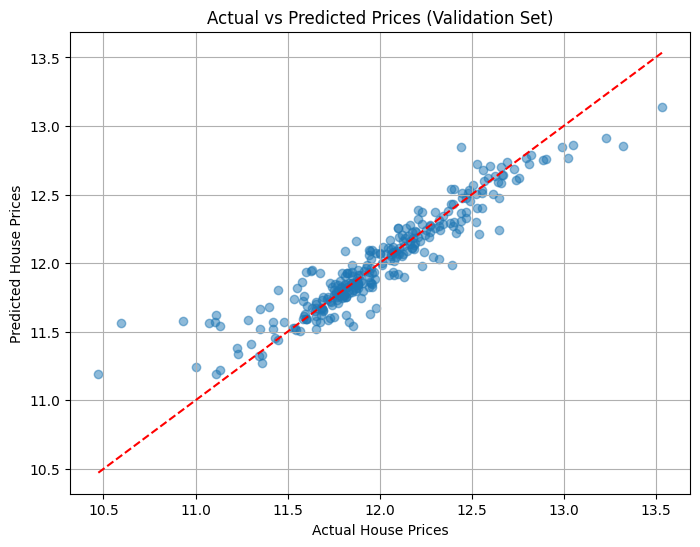

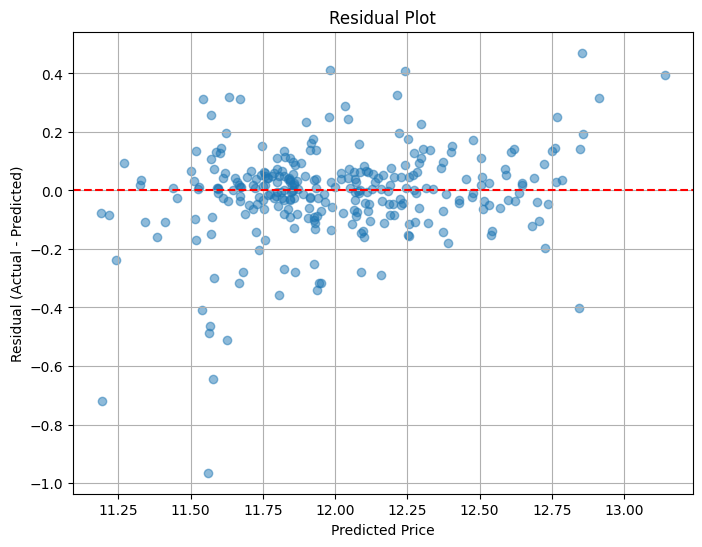

In [ ]:
# ===============================================
# ✨ Random Forest Regression From Scratch
#    - House Price Prediction
#    - MAPE evaluation
# ===============================================

from google.colab import files
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# ================================
# 🔢 Feature Selection
# ================================
selected_features = [
     'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

# Select features from existing preprocessed data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_selected)
X_val = scaler.transform(X_val_selected)


# ================================
# ⚖️ Utilities: MSE & Best Split
# ================================
def mse(y):
    return np.mean((y - np.mean(y))**2)

def best_split(X, y, max_features=None):
    feature_indices = np.arange(X.shape[1])
    if max_features is not None:
      feature_indices = np.random.choice(feature_indices, size=max_features, replace=False)

    best_feature, best_threshold, best_loss = None, None, float('inf')
    for feature_idx in feature_indices:
        thresholds = np.unique(X[:, feature_idx])
        for threshold in thresholds:
            left_idx = X[:, feature_idx] <= threshold
            right_idx = ~left_idx
            if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                continue
            loss = (len(y[left_idx]) * mse(y[left_idx]) + len(y[right_idx]) * mse(y[right_idx])) / len(y)
            if loss < best_loss:
                best_feature, best_threshold, best_loss = feature_idx, threshold, loss
    return best_feature, best_threshold

# ================================
# 🤳 Decision Tree Regressor (CART)
# ================================

class DecisionTreeRegressor:
    def __init__(self, max_depth=10, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def _fit(self, X, y, depth):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)

        feature, threshold = best_split(X, y, self.max_features)
        if feature is None:
            return np.mean(y)

        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx

        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._fit(X[left_idx], y[left_idx], depth + 1),
            'right': self._fit(X[right_idx], y[right_idx], depth + 1)
        }

    def fit(self, X, y):
        self.tree = self._fit(X, y, depth=0)

    def predict_row(self, row, node):
        if not isinstance(node, dict):
            return node
        if row[node['feature']] <= node['threshold']:
            return self.predict_row(row, node['left'])
        else:
            return self.predict_row(row, node['right'])

    def predict(self, X):
        return np.array([self.predict_row(row, self.tree) for row in X]).reshape(-1, 1)

# ================================
# 🌳 Random Forest Regressor
# ================================

class RandomForestRegressorFromScratch:
    def __init__(self, n_estimators=10, max_depth=10, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.feature_importances_ = np.zeros(X_train.shape[1])

    def fit(self, X, y):
        self.trees = []
        feature_counts = np.zeros(X.shape[1])
        for _ in range(self.n_estimators):
            idxs = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[idxs], y[idxs]
            tree = DecisionTreeRegressor(max_depth=self.max_depth, max_features=self.max_features)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

            def count_features(node):
                if isinstance(node, dict):
                    feature_counts[node['feature']] += 1
                    count_features(node['left'])
                    count_features(node['right'])
            count_features(tree.tree)

        self.feature_importances_ = feature_counts / feature_counts.sum()

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

# ================================
# 📊 Train Random Forest and Evaluate MAPE
# ================================

rf_model = RandomForestRegressorFromScratch(n_estimators=150, max_depth=10, max_features=4)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)
mape_rf = np.mean(np.abs(y_pred_rf - y_val) / y_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2 = r2_score(y_val, y_pred_rf)

print(f"📈 Mean Absolute Percentage Error on Validation Set (Random Forest): {mape_rf}")
print(f"📈 Root Mean Square Error on Validation Set (Random Forest): {rmse_rf:.4f}")
print(f"📈 R² Score on Validation Set (Random Forest): {r2:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred_rf, alpha=0.5)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs Predicted Prices (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # Đường y = x
plt.grid(True)
plt.show()

y_val_flat = y_val.ravel()  # or use .flatten()
y_pred_rf = y_pred_rf.ravel()
residuals = y_val_flat - y_pred_rf

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


#Also Test using sklearn but for RandomForest


Mean Absolute Percentage Error on Validation Set: 0.009133972713830384


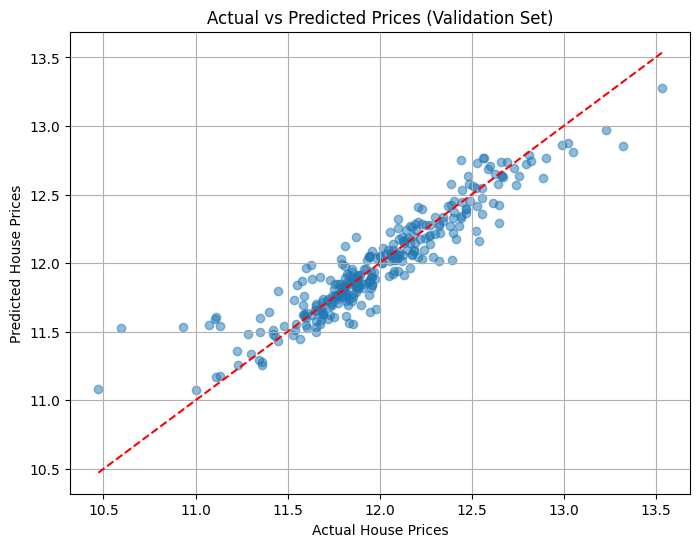

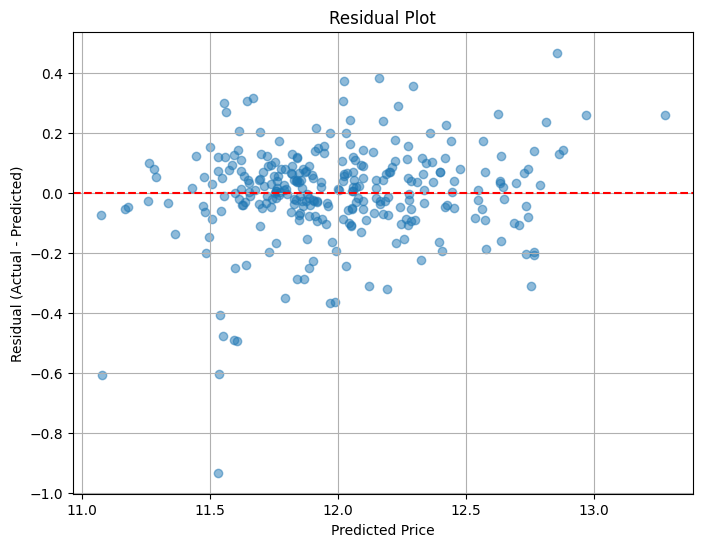

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# List of features
selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

# Standardize data
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train_selected)
x_val   = scaler.transform(X_val_selected)

# Train Random Forest
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(x_train, y_train.ravel())

# Predict on validation set
y_val_pred = model.predict(x_val)

# MAPE
mape = mean_absolute_percentage_error(y_val, y_val_pred)
print(f"Mean Absolute Percentage Error on Validation Set: {mape:}")
y_val_flat = y_val.ravel()  # or use .flatten()
residuals = y_val_flat - y_val_pred

# Actual vs Predicted Price Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("Actual vs Predicted Prices (Validation Set)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.grid(True)
plt.show()

# Residual Plot Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()


# Create submission.csv




In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 12 features đã chọn
selected_features = [
    'OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'LotArea'
]

# Tách X và y
X_train = train_df[selected_features]
y_train = train_df['SalePrice']

# Xử lý missing
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_test = test_df[selected_features].fillna(X_train.median(numeric_only=True))

# Scale giống Linear Regression để đảm bảo công bằng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Chia một phần nhỏ để đánh giá MAPE (optional)
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.1, random_state=42)

# Huấn luyện mô hình Random Forest mạnh
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
model.fit(X_tr, y_tr)

# Dự đoán và đánh giá MAPE
val_preds = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, val_preds)
print(f"📊 MAPE (validation): {mape}")

# Dự đoán trên test
test_preds = model.predict(X_test_scaled)

# Export file submission
submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': test_preds
})
submission_df.to_csv("submission.csv", index=False)
print("✅ File submission.csv has been created!")

from google.colab import files
files.download("submission.csv")


📊 MAPE (validation): 0.09939516993936802
✅ File submission.csv has been created!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>